In [92]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 255)

In [3]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2023']:
        for month in ['6', '7', '8', '9']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [4]:
len(subjects)

6483

In [5]:
data = pd.DataFrame(subjects)

In [76]:
def get_week_edition(data, focus_media, edition, week):
    week_start = datetime.date(year=2023, month=6, day=5) + datetime.timedelta(weeks=week)
    week_end = week_start + datetime.timedelta(days=8 if focus_media=='tf1' else 7)
    week_data = data[(data.media == focus_media)
                 & (data["date"] >= week_start.strftime("%Y-%m-%d")) 
                 & (data["date"] < week_end.strftime("%Y-%m-%d")) ].copy()

    # extract edition
    if focus_media == 'france2' and edition == "20h":
        week_data = week_data[['20h' in x for x in week_data.urlTvNews]].copy()
    if focus_media == 'france2' and edition == "13h":
        week_data = week_data[['13h' in x for x in week_data.urlTvNews]].copy()
    if focus_media == 'tf1' and edition == "20h":
        week_data = week_data[[('20h' in x) or ('we' in x and (d[11:13] >= "20" or d[11:13] <= "13")) for x,d in zip(week_data.urlTvNews, week_data.date)]].copy()

    
    # get subject
    if focus_media == 'tf1':
        topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
        week_data['topic'] = [topic_pattern.match(u).group(1) for u in week_data.url]
        
    if focus_media == 'france2':
        topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
        week_data['topic'] = [topic_pattern.match(u).group(1).split('/')[0] 
                                  for u in [x.replace('https://www.francetvinfo.frhttps://www.francetvinfo.fr', 'https://www.francetvinfo.fr') for x in week_data.url]]

    if focus_media == 'france2':
        week_data['formatted_date'] = [d.strftime('%d %B, %A') for d in pd.to_datetime(week_data.date)]  
    if focus_media == 'tf1':
        week_data['formatted_date'] = [(d - datetime.timedelta(hours=20)+datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(week_data.date)]
        week_data = week_data[(week_data['formatted_date'] >= week_start.strftime('%d %B, %A')) 
                                & (week_data['formatted_date'] < (week_end - datetime.timedelta(days=1)).strftime('%d %B, %A'))]
        
    return week_data

In [77]:
week_edition = get_week_edition(data, 'tf1', '20h', 0)

In [78]:
len(week_edition)

62

<Axes: xlabel='formatted_date'>

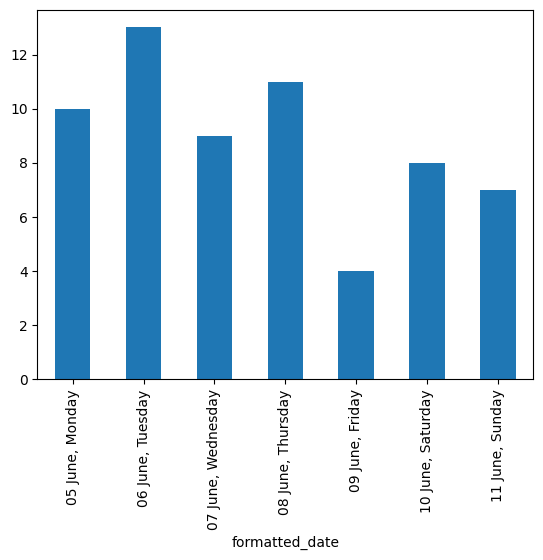

In [79]:
week_edition.formatted_date.value_counts().sort_index().plot(kind='bar')

In [80]:
export = week_edition.sort_values('formatted_date')[['formatted_date', 'title', 'description', 'topic',  'url']]
export.head()

,formatted_date,title,description,topic,url
4582,"05 June, Monday",VIDÉO - Prix de l'essence : pourquoi ils risquent de repartir à la hausse cet été,Combien paierez-vous votre plein d'essence ou de gazole sur la route des vacances ? TF1 répond à vos questions sur l'évolution des prix. Ceux-ci risquent de nouveau d'augmenter dans les prochaines semaines. Si les prix des carburants ont légèrement b...,conso,https://www.tf1info.fr/conso/video-tf1-carburants-essence-et-diesel-les-prix-vont-ils-augmenter-ou-baisser-cet-ete-2259436.html
4590,"05 June, Monday","VIDÉO - Orages, grêle, pluies torrentielles... les intempéries frappent encore dans le sud","Des orages accompagnés de pluies torrentielles et de grêle ont à nouveau balayé la moitié sud de la France ce lundi 5 juin. Des phénomènes météorologiques intenses qui se répètent ces dernières semaines. Impuissants, les sinistrés ne peuvent que const...",meteo,https://www.tf1info.fr/meteo/video-tf1-20h-orages-grele-pluies-torrentielles-les-intemperies-frappent-a-nouveau-dans-le-sud-les-images-2259441.html
4588,"05 June, Monday",VIDÉO - Prix des courses : le panier de TF1 entrevoit (enfin) une baisse,"Depuis le début de l’année, le 20H de TF1 remplit chaque mois le même panier de courses, composé de quinze produits. En ce mois de juin, deux d'entre eux ont baissé et un seul augmente. L'horizon semble s'éclaircir à la caisse des supermarchés. Vous ...",conso,https://www.tf1info.fr/conso/video-pouvoir-d-achat-prix-des-courses-le-panier-de-tf1-entrevoit-enfin-une-baisse-dans-les-supermarches-2259425.html
4584,"05 June, Monday","VIDÉO - Everest : les images du sauvetage miraculeux dans ""la zone de la mort""","En détresse dans ""la zone de mort"" de l'Everest, un alpiniste a été sauvé in extremis par un guide népalais en cette fin de saison particulièrement meurtrière au Népal. Le sherpa, sur le point d'atteindre le sommet de l'Everest avec l'un de ses client...",international,https://www.tf1info.fr/international/video-tf1-alpinisme-ascension-de-l-everest-le-sauvetage-miraculeux-d-un-sherpa-a-8000-metres-d-altitude-2259442.html
4580,"05 June, Monday",VIDÉO - Chine : ces poissons peuvent valoir plus cher qu'une Porsche,"Tout le monde connaît les concours animaliers où l'on juge de la beauté de chiens ou de chats. En Chine, l'une des compétitions les plus populaires se tient chaque année à Canton. Sauf qu'ici, pas de bêtes à poils mais d'étonnants poissons, qui attire...",international,https://www.tf1info.fr/international/video-tf1-en-chine-des-poissons-dragons-vendus-au-prix-d-une-porsche-jusqu-a-130000-euros-2259437.html


In [81]:
annot = pd.read_csv('data/summer2023_tf1_june5_annotated.csv')

In [82]:
export = export.merge(annot[['title', 'climat']], how='left', on='title')

In [83]:
export.to_csv('data/summer2023_tf1_june5.csv' ,index=False)

# Analyse

In [103]:
tf1 = pd.read_csv('data/summer2023_tf1_june5.csv')

In [104]:
france2 = pd.read_csv('data/summer2023_france2_june5.csv')

<Axes: title={'center': 'france2'}>

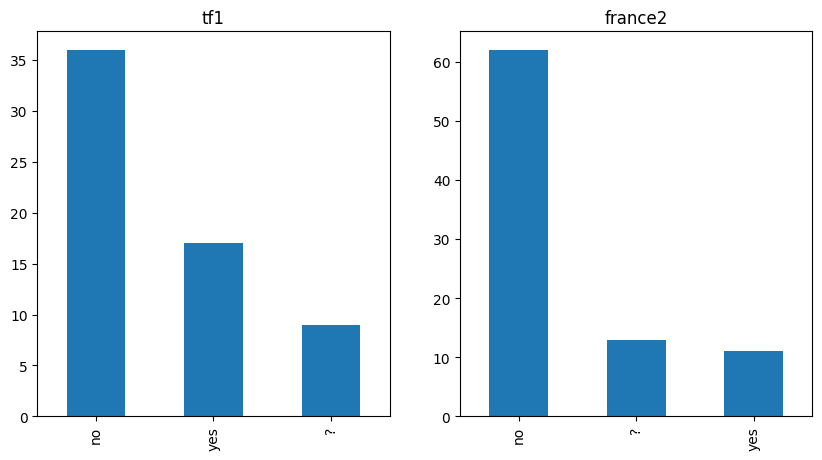

In [115]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
tf1.climat.value_counts().plot(kind=('bar'), ax=axes[0], title='tf1', xlabel='')
france2.climat.value_counts().plot(kind=('bar'), ax=axes[1], title='france2', xlabel='')

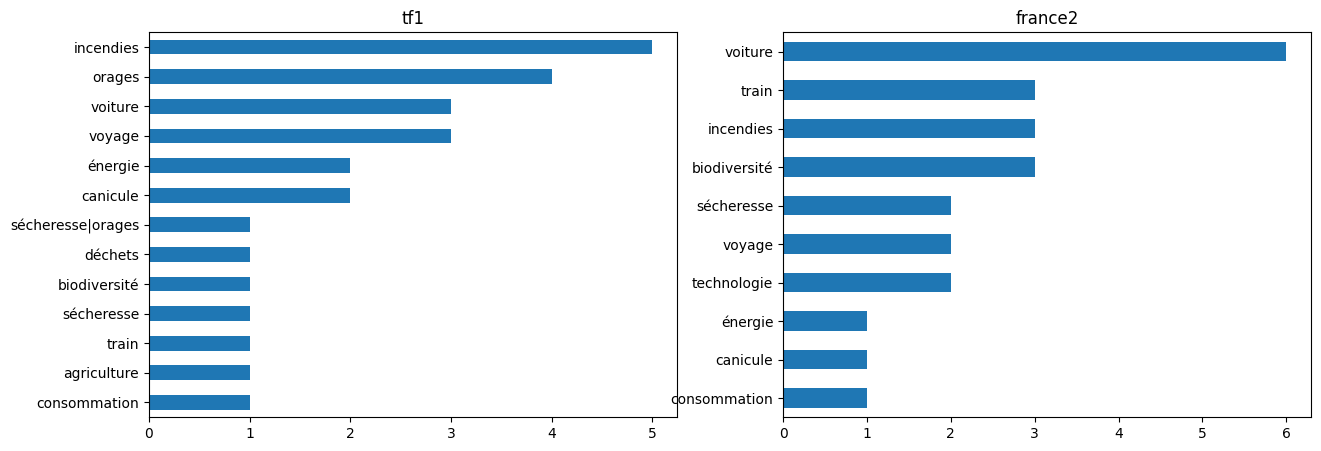

In [116]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tf1.climat_topic.value_counts().plot(kind='barh', ax=axes[0], title='tf1', ylabel='').invert_yaxis()
france2.climat_topic.value_counts().plot(kind='barh', ax=axes[1], title='france2', ylabel='').invert_yaxis()

# Auto detection

In [131]:
tf1_all = []
for w in range(15):
    tf1_all.append(get_week_edition(data, 'tf1', '20h', w))

In [132]:
tf1_all = pd.concat(tf1_all)

In [133]:
len(tf1_all)

795

In [215]:
france2_all = []
for w in range(15):
    france2_all.append(get_week_edition(data, 'france2', '20h', w))

In [216]:
france2_all = pd.concat(france2_all)

In [217]:
len(france2_all)

1279

In [204]:
keywords = {
    'incendies' : ['incendie', 'incendies', 'feux', 'pompiers', 'feu'],
    'orages' : ['orage', 'orages', 'intempéries', 'pluie', 'pluies', 'grêle', 'innodations', 'innodation'],
    'énergie' : ['gaz', 'solaire', 'solaires', 'éoliennes', 'éolienne', 'éolien'],
    'canicule' : ['chaleur', 'chaleurs', 'température', 'températures', 'canicule', 'canicules', 'fraicheur', 'climatisation', 'climatiseur', 'climatiseusrs'],
    'sécheresse' : ['eau', 'sécheresse', 'phréatique', 'phréatiques', 'bassines', 'bassine', 'soline'],
    'voiture' : ['voiture', 'voitures', 'automobile', 'automobilies', 'automobilistes', 'carburant', 'pompe', 'péage', 'péages', 'permis', 'conduire'],
    'train' : ['train', 'trains', 'rail', 'rails', 'rer', 'ferroviaire', 'ferroviaires', 'sncf', 'ratp'],
    'déchets' : [],
    'biodiversité' : [],
    'voyage' : [],
    'consommation' : []
}

In [205]:
topic = 'train'

In [203]:
tf1_all[['ferroviaire' in t.lower() for t in tf1_all.title]][['formatted_date', 'title']]

,formatted_date,title
5993,"19 August, Saturday",VIDÉO - Panne entre Hendaye et Bordeaux : pagaille ferroviaire dans le Sud-ouest


In [206]:
tf1_all[[any(w in keywords[topic] for w in t.lower().split()) for t in tf1_all.title]][['formatted_date', 'title']]

,formatted_date,title
4667,"09 June, Friday",VIDÉO - SNCF : pagaille et retards dans deux gares parisiennes après des problèmes d'alimentation électrique
4252,"14 June, Wednesday",VIDÉO - Trains cherchent réparateurs : la SNCF recrute plus de 1000 personnes pour la maintenance des rames
4318,"13 June, Tuesday",VIDÉO - Transports dans les grandes villes : les RER sont-ils sur la bonne voie ?
4760,"12 June, Monday",VIDÉO - SNCF : mais pourquoi les billets sont-ils si chers cet été ?
4399,"22 June, Thursday","VIDÉO - Billets de train : encore quelques places disponibles pour cet été, mais au prix fort"
5273,"08 July, Saturday","REPORTAGE - Vacances : le train de nuit, vraiment un bon plan ?"
4880,"13 July, Thursday","Billets de train : Renfe, Trenitalia... la course aux petits prix face à la SNCF"
4885,"13 July, Thursday",Renfe : à bord du premier train espagnol en France
5163,"17 July, Monday","VIDÉO - SNCF : nouveaux plafonds pour la carte ""Avantage"""
5129,"29 July, Saturday","REPORTAGE - ""Ça commence à être énervant"" : l'agacement des voyageurs face aux pannes de la SNCF"


In [222]:
tf1_topic= {}

In [241]:
for topic in keywords.keys():
    if len(keywords[topic]) == 0:
        continue
    tf1_topic[topic] = tf1_all[[any(w in keywords[topic] for w in t.lower().split()) for t in tf1_all.title]][['formatted_date', 'title', 'description', 'url']]

In [224]:
tf1_topic_counts = pd.Series({t:len(s) for t,s in tf1_topic.items()}).sort_values(ascending=False)

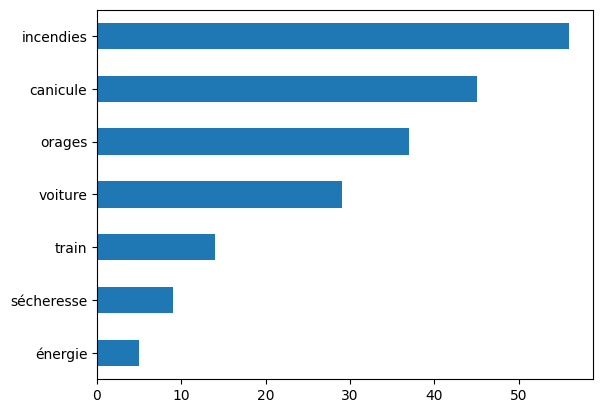

In [225]:
tf1_topic_counts.plot(kind='barh').invert_yaxis()

In [226]:
france_2_topic = {}

In [240]:
for topic in keywords.keys():
    if len(keywords[topic]) == 0:
        continue
    france_2_topic[topic] = france2_all[[any(w in keywords[topic] for w in t.lower().split()) for t in france2_all.title]][['formatted_date', 'title', 'description', 'url']]

In [231]:
france_2_topic_counts = pd.Series({t:len(s) for t,s in france_2_topic.items()}).sort_values(ascending=False)

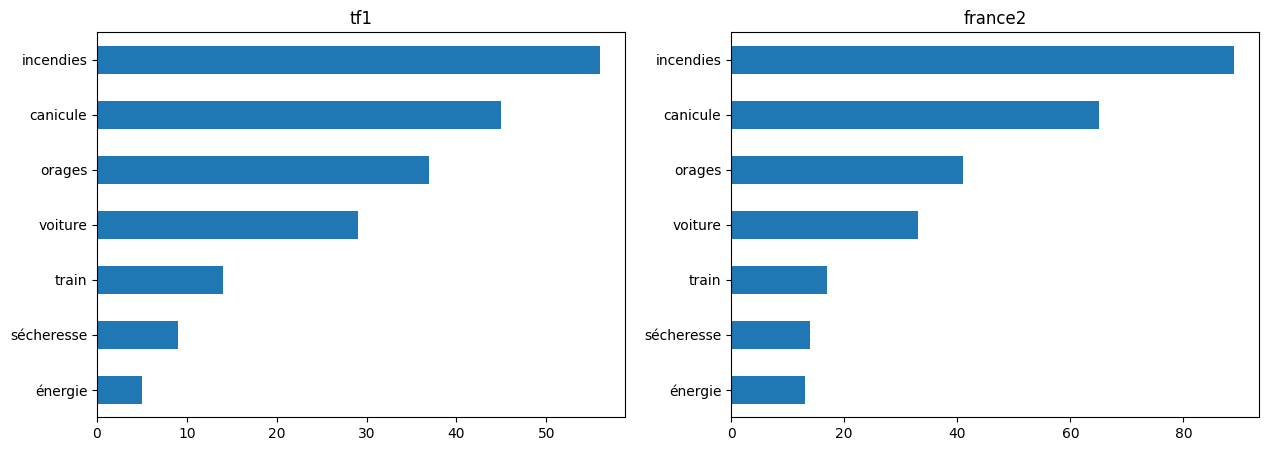

In [233]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tf1_topic_counts.plot(kind='barh', ax=axes[0], title='tf1', ylabel='').invert_yaxis()
france_2_topic_counts.plot(kind='barh', ax=axes[1], title='france2', ylabel='').invert_yaxis()

# Export

In [238]:
tf1_all.sort_values('date')[['formatted_date', 'title', 'description', 'url']].to_csv('data/summer2023_tf1_all.csv', index=False)

In [239]:
france2_all.sort_values('date')[['formatted_date', 'title', 'description', 'url']].to_csv('data/summer2023_france2_all.csv', index=False)

In [247]:
pd.concat(tf1_topic).reset_index().rename({'level_0': 'topic'}, axis=1).drop('level_1', axis=1).to_csv('data/summer2023_tf1_topics.csv', index=False)

In [249]:
pd.concat(france_2_topic).reset_index().rename({'level_0': 'topic'}, axis=1).drop('level_1', axis=1).to_csv('data/summer2023_france2_topics.csv', index=False)